In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
from matplotlib import font_manager, rc
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping
font_path = "c:\WINDOWS\Fonts\GULIM.TTC"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
plt.rc('font', size=8) 

# 이상치 탐지 함수 (IQR)

In [2]:
def findOutliers(dataframe: pd.DataFrame, col : str) -> tuple:
    '''
    해당 DataFrame의 칼럼의 이상치에 해당하는 데이터 프레임과 개수를 알려드립니다.
    '''
    q1 = dataframe[col].quantile(0.25)
    q3 = dataframe[col].quantile(0.75)
    
    iqr = q3-q1
    minimum = q1 - (1.5) * iqr
    maximum = q3 + (1.5) * iqr

    outliers = dataframe[(dataframe[col] < minimum) | (dataframe[col] > maximum)]

    return (outliers[[col]],len(outliers))

In [3]:
dataframe = pd.read_csv(r'C:\Users\hyssk\AICE_\open\train.csv')
dataframe.drop(columns='ID',inplace=True)
dataframe

,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급
0,12480000,36 months,6 years,RENT,72000000,18.90,15,부채 통합,0,0,0.0,0.0,0.0,C
1,14400000,60 months,10+ years,MORTGAGE,130800000,22.33,21,주택 개선,0,373572,234060.0,0.0,0.0,B
2,12000000,36 months,5 years,MORTGAGE,96000000,8.60,14,부채 통합,0,928644,151944.0,0.0,0.0,A
3,14400000,36 months,8 years,MORTGAGE,132000000,15.09,15,부채 통합,0,325824,153108.0,0.0,0.0,C
4,18000000,60 months,Unknown,RENT,71736000,25.39,19,주요 구매,0,228540,148956.0,0.0,0.0,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96289,14400000,36 months,10+ years,MORTGAGE,210000000,9.33,33,신용 카드,0,974580,492168.0,0.0,0.0,C
96290,28800000,60 months,10+ years,MORTGAGE,132000000,5.16,25,주택 개선,0,583728,855084.0,0.0,0.0,E
96291,14400000,36 months,1 year,MORTGAGE,84000000,11.24,22,신용 카드,0,1489128,241236.0,0.0,0.0,A
96292,15600000,36 months,5 years,MORTGAGE,66330000,17.30,21,부채 통합,2,1378368,818076.0,0.0,0.0,D


In [4]:
dataframe['근로기간']=dataframe['근로기간'].replace('1 years','1 year')
dataframe['근로기간']=dataframe['근로기간'].replace('3','3 years')
dataframe['근로기간']=dataframe['근로기간'].replace('<1 year','< 1 year')
dataframe['근로기간']=dataframe['근로기간'].replace('10+years','10+ years')
dataframe['근로기간'].value_counts()

10+ years    32481
2 years       8450
< 1 year      8144
3 years       7670
1 year        6305
Unknown       5671
5 years       5665
4 years       5588
8 years       4888
6 years       3874
7 years       3814
9 years       3744
Name: 근로기간, dtype: int64

# 범주형 데이터 전처리하기 (Pandas.factorize())

In [5]:
categorical_columns = dataframe.select_dtypes('object').columns
categorical_columns # 범주형 칼럼명들의 리스트

Index(['대출기간', '근로기간', '주택소유상태', '대출목적', '대출등급'], dtype='object')

In [6]:
dataframe[['대출기간']] = pd.factorize(dataframe['대출기간'])[0].reshape(-1,1)
dataframe[['대출기간']]

,대출기간
0,0
1,1
2,0
3,0
4,1
...,...
96289,0
96290,1
96291,0
96292,0


In [7]:
dataframe['대출기간'].value_counts()

0    64479
1    31815
Name: 대출기간, dtype: int64

In [8]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
dataframe['근로기간'] = le.fit_transform(dataframe['근로기간'])
dataframe[['근로기간']]


,근로기간
0,6
1,1
2,5
3,8
4,11
...,...
96289,1
96290,1
96291,0
96292,5


In [9]:
dataframe

,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급
0,12480000,0,6,RENT,72000000,18.90,15,부채 통합,0,0,0.0,0.0,0.0,C
1,14400000,1,1,MORTGAGE,130800000,22.33,21,주택 개선,0,373572,234060.0,0.0,0.0,B
2,12000000,0,5,MORTGAGE,96000000,8.60,14,부채 통합,0,928644,151944.0,0.0,0.0,A
3,14400000,0,8,MORTGAGE,132000000,15.09,15,부채 통합,0,325824,153108.0,0.0,0.0,C
4,18000000,1,11,RENT,71736000,25.39,19,주요 구매,0,228540,148956.0,0.0,0.0,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96289,14400000,0,1,MORTGAGE,210000000,9.33,33,신용 카드,0,974580,492168.0,0.0,0.0,C
96290,28800000,1,1,MORTGAGE,132000000,5.16,25,주택 개선,0,583728,855084.0,0.0,0.0,E
96291,14400000,0,0,MORTGAGE,84000000,11.24,22,신용 카드,0,1489128,241236.0,0.0,0.0,A
96292,15600000,0,5,MORTGAGE,66330000,17.30,21,부채 통합,2,1378368,818076.0,0.0,0.0,D


In [10]:
dataframe['주택소유상태'].values

array(['RENT', 'MORTGAGE', 'MORTGAGE', ..., 'MORTGAGE', 'MORTGAGE',
       'RENT'], dtype=object)

In [11]:
from sklearn.preprocessing import OneHotEncoder

oh=OneHotEncoder()
encoder = oh.fit_transform(dataframe[['주택소유상태']]).toarray()
print(f'OneHotEncoder 이해하기:',type(oh.fit_transform(dataframe[['주택소유상태']])))
print(f'OneHotEncoder.fit_transform 자료 \n',oh.fit_transform(dataframe[['주택소유상태']]).toarray())
print(f'OneHotEncode된 칼럼명들 : {oh.get_feature_names_out()}')
print(f'OneHotEncode 하려고하는 칼럼의 수준: {oh.categories_}')
print(f'OneHotEncoder의 feature_names_in_(어떤 칼럼이 인코딩되기 위해 입력됐는가?): {oh.feature_names_in_}')

OneHotEncoder 이해하기: <class 'scipy.sparse.csr.csr_matrix'>
OneHotEncoder.fit_transform 자료 
 [[0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 ...
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]]
OneHotEncode된 칼럼명들 : ['주택소유상태_ANY' '주택소유상태_MORTGAGE' '주택소유상태_OWN' '주택소유상태_RENT']
OneHotEncode 하려고하는 칼럼의 수준: [array(['ANY', 'MORTGAGE', 'OWN', 'RENT'], dtype=object)]
OneHotEncoder의 feature_names_in_(어떤 칼럼이 인코딩되기 위해 입력됐는가?): ['주택소유상태']


In [12]:
dataframe[['주택소유상태']]

,주택소유상태
0,RENT
1,MORTGAGE
2,MORTGAGE
3,MORTGAGE
4,RENT
...,...
96289,MORTGAGE
96290,MORTGAGE
96291,MORTGAGE
96292,MORTGAGE


In [13]:
encoded_state=pd.DataFrame(encoder, columns=oh.get_feature_names_out())
dataframe = pd.concat([dataframe,encoded_state],axis=1)
dataframe.drop(columns='주택소유상태',inplace=True)
dataframe

,대출금액,대출기간,근로기간,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급,주택소유상태_ANY,주택소유상태_MORTGAGE,주택소유상태_OWN,주택소유상태_RENT
0,12480000,0,6,72000000,18.90,15,부채 통합,0,0,0.0,0.0,0.0,C,0.0,0.0,0.0,1.0
1,14400000,1,1,130800000,22.33,21,주택 개선,0,373572,234060.0,0.0,0.0,B,0.0,1.0,0.0,0.0
2,12000000,0,5,96000000,8.60,14,부채 통합,0,928644,151944.0,0.0,0.0,A,0.0,1.0,0.0,0.0
3,14400000,0,8,132000000,15.09,15,부채 통합,0,325824,153108.0,0.0,0.0,C,0.0,1.0,0.0,0.0
4,18000000,1,11,71736000,25.39,19,주요 구매,0,228540,148956.0,0.0,0.0,B,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96289,14400000,0,1,210000000,9.33,33,신용 카드,0,974580,492168.0,0.0,0.0,C,0.0,1.0,0.0,0.0
96290,28800000,1,1,132000000,5.16,25,주택 개선,0,583728,855084.0,0.0,0.0,E,0.0,1.0,0.0,0.0
96291,14400000,0,0,84000000,11.24,22,신용 카드,0,1489128,241236.0,0.0,0.0,A,0.0,1.0,0.0,0.0
96292,15600000,0,5,66330000,17.30,21,부채 통합,2,1378368,818076.0,0.0,0.0,D,0.0,1.0,0.0,0.0


In [14]:
dataframe[['대출등급']].value_counts()

대출등급
B       28817
C       27623
A       16772
D       13354
E        7354
F        1954
G         420
dtype: int64

In [15]:
onehot_columns = ['대출목적'] # 원핫인코딩할 칼럼

ohe = OneHotEncoder()
for col in onehot_columns:
   array=ohe.fit_transform(dataframe[[col]]).toarray()
   print(f'[{col}]: \n{array} 입니다. \n')
   cols=pd.DataFrame(array,columns=ohe.get_feature_names_out())
   dataframe=pd.concat([dataframe,cols],axis=1)
dataframe.drop(columns=['대출목적'],inplace=True)
dataframe

[대출목적]: 
[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] 입니다. 



,대출금액,대출기간,근로기간,연간소득,부채_대비_소득_비율,총계좌수,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,...,대출목적_소규모 사업,대출목적_신용 카드,대출목적_의료,대출목적_이사,대출목적_자동차,대출목적_재생 에너지,대출목적_주요 구매,대출목적_주택,대출목적_주택 개선,대출목적_휴가
0,12480000,0,6,72000000,18.90,15,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,14400000,1,1,130800000,22.33,21,0,373572,234060.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,12000000,0,5,96000000,8.60,14,0,928644,151944.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,14400000,0,8,132000000,15.09,15,0,325824,153108.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,18000000,1,11,71736000,25.39,19,0,228540,148956.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96289,14400000,0,1,210000000,9.33,33,0,974580,492168.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96290,28800000,1,1,132000000,5.16,25,0,583728,855084.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
96291,14400000,0,0,84000000,11.24,22,0,1489128,241236.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96292,15600000,0,5,66330000,17.30,21,2,1378368,818076.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 수치형 데이터칼럼 분포 확인하기. 어느 것도 정규분포를 따르는 것이 없음`

<Figure size 640x480 with 0 Axes>

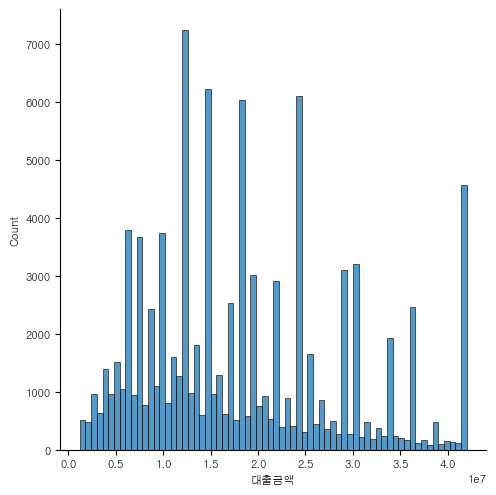

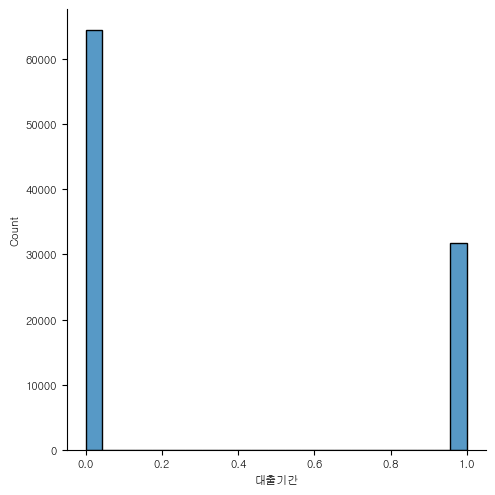

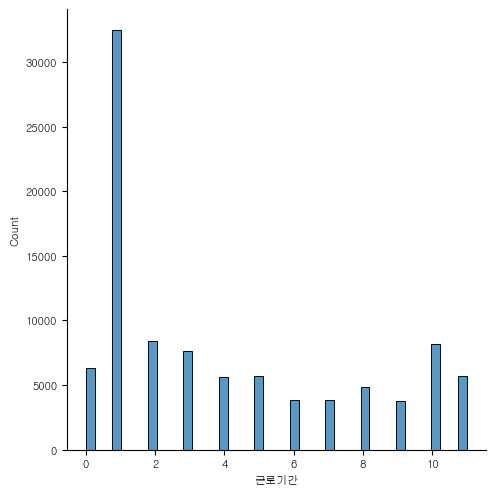

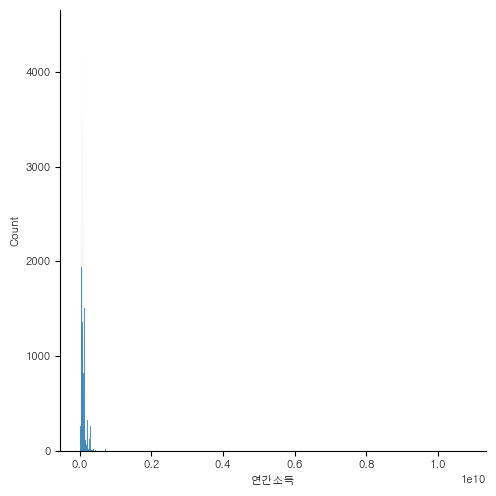

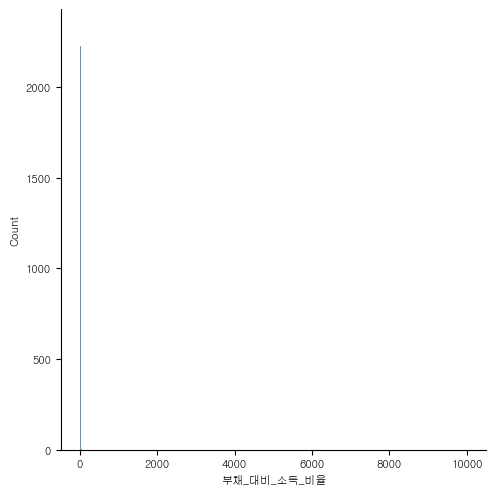

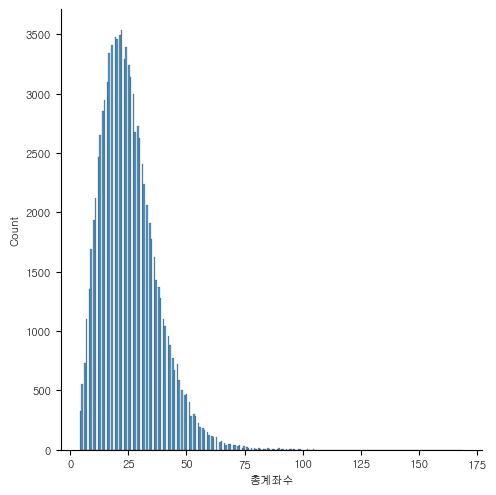

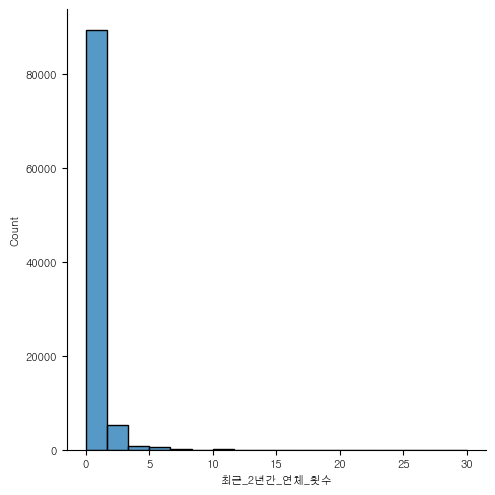

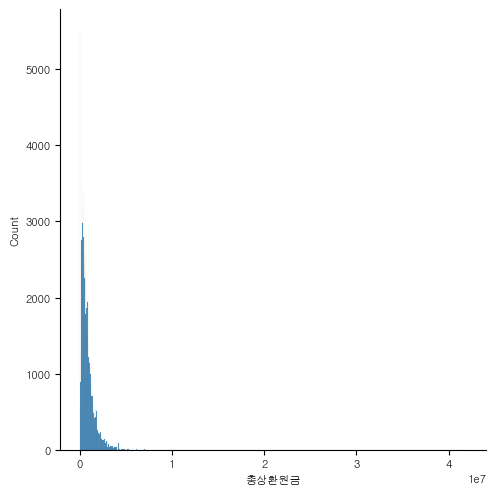

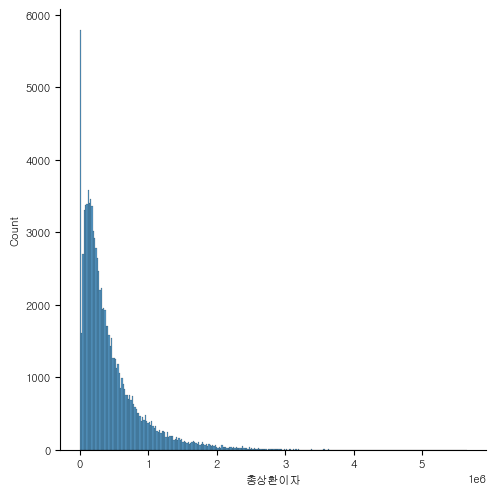

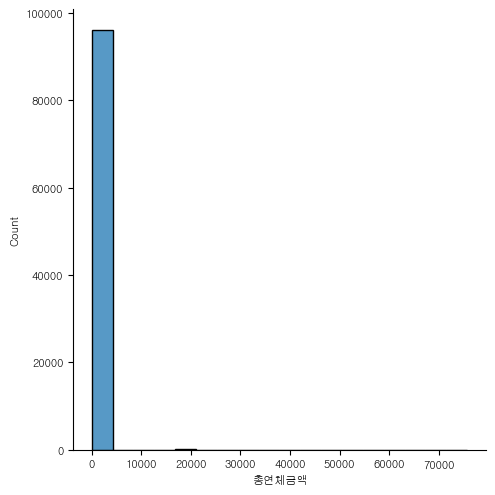

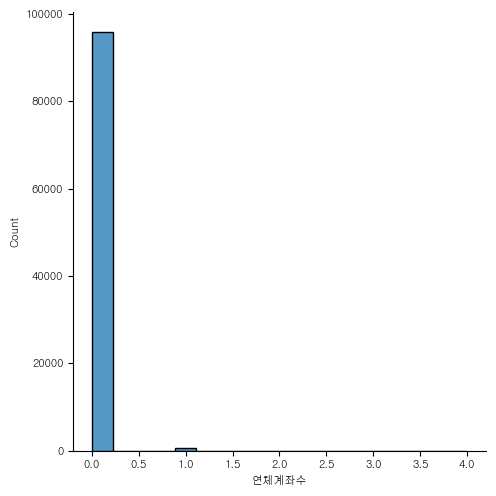

In [16]:
plt.figure()
for col in ['대출금액','대출기간','근로기간','연간소득','부채_대비_소득_비율','총계좌수','최근_2년간_연체_횟수','총상환원금','총상환이자','총연체금액','연체계좌수']:
    sns.displot(dataframe,x=col)
plt.show()

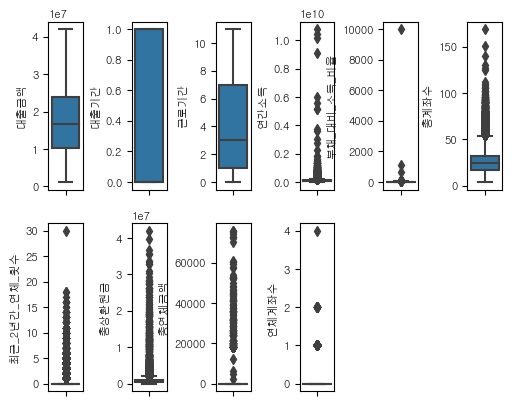

In [17]:
# 적용하기 전 boxplot
plt.figure()
for i, col in enumerate(['대출금액','대출기간','근로기간','연간소득','부채_대비_소득_비율','총계좌수','최근_2년간_연체_횟수','총상환원금','총연체금액','연체계좌수']):
    plt.subplot(2,12,(i+1)*2)
    sns.boxplot(dataframe,y=col)
plt.show()

In [18]:
from sklearn.preprocessing import RobustScaler

rs=RobustScaler()
for col in ['대출금액','대출기간','근로기간','연간소득','부채_대비_소득_비율','총계좌수','최근_2년간_연체_횟수','총상환원금','총상환이자','총연체금액','연체계좌수']:
    dataframe[col] = rs.fit_transform(dataframe[[col]])
dataframe

,대출금액,대출기간,근로기간,연간소득,부채_대비_소득_비율,총계좌수,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,...,대출목적_소규모 사업,대출목적_신용 카드,대출목적_의료,대출목적_이사,대출목적_자동차,대출목적_재생 에너지,대출목적_주요 구매,대출목적_주택,대출목적_주택 개선,대출목적_휴가
0,-0.313043,0.0,0.500000,-0.108696,0.012413,-0.600000,0.0,-0.799589,-0.658871,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.173913,1.0,-0.333333,0.956522,0.278510,-0.200000,0.0,-0.299830,-0.121543,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-0.347826,0.0,0.333333,0.326087,-0.786656,-0.666667,0.0,0.442737,-0.310055,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.173913,0.0,0.833333,0.978261,-0.283165,-0.600000,0.0,-0.363706,-0.307383,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.086957,1.0,1.333333,-0.113478,0.515904,-0.333333,0.0,-0.493852,-0.316915,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96289,-0.173913,0.0,-0.333333,2.391304,-0.730023,0.600000,0.0,0.504190,0.470992,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96290,0.869565,1.0,-0.333333,0.978261,-1.053530,0.066667,0.0,-0.018686,1.304132,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
96291,-0.173913,0.0,-0.500000,0.108696,-0.581846,-0.133333,0.0,1.192545,-0.105069,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96292,-0.086957,0.0,0.333333,-0.211413,-0.111715,-0.200000,2.0,1.044372,1.219174,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


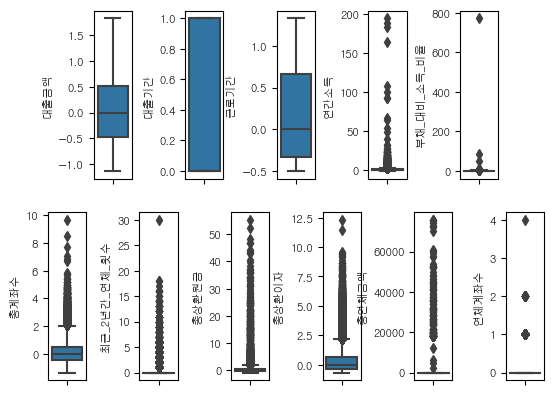

,대출금액,대출기간,근로기간,연간소득,부채_대비_소득_비율,총계좌수,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,...,대출목적_소규모 사업,대출목적_신용 카드,대출목적_의료,대출목적_이사,대출목적_자동차,대출목적_재생 에너지,대출목적_주요 구매,대출목적_주택,대출목적_주택 개선,대출목적_휴가
0,-0.313043,0.0,0.500000,-0.108696,0.012413,-0.600000,0.0,-0.799589,-0.658871,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.173913,1.0,-0.333333,0.956522,0.278510,-0.200000,0.0,-0.299830,-0.121543,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-0.347826,0.0,0.333333,0.326087,-0.786656,-0.666667,0.0,0.442737,-0.310055,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.173913,0.0,0.833333,0.978261,-0.283165,-0.600000,0.0,-0.363706,-0.307383,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.086957,1.0,1.333333,-0.113478,0.515904,-0.333333,0.0,-0.493852,-0.316915,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96289,-0.173913,0.0,-0.333333,2.391304,-0.730023,0.600000,0.0,0.504190,0.470992,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96290,0.869565,1.0,-0.333333,0.978261,-1.053530,0.066667,0.0,-0.018686,1.304132,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
96291,-0.173913,0.0,-0.500000,0.108696,-0.581846,-0.133333,0.0,1.192545,-0.105069,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96292,-0.086957,0.0,0.333333,-0.211413,-0.111715,-0.200000,2.0,1.044372,1.219174,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
plt.figure() # 적용한 뒤 boxplot
for i, col in enumerate(['대출금액','대출기간','근로기간','연간소득','부채_대비_소득_비율','총계좌수','최근_2년간_연체_횟수','총상환원금','총상환이자','총연체금액','연체계좌수']):
    plt.subplot(2,11,(i+1)*2)
    sns.boxplot(dataframe,y=col)
plt.show()
dataframe


# 이상치 처리에 대한 고찰

Boxplot 해보면 많은 칼럼이 이상치라고 뜹니다.

정말 시각화된 정보가 이상치인지 확인해봅시다.



해당 칼럼 [대출금액] 의 이상치 개수: 0개
해당 칼럼 [대출기간] 의 이상치 개수: 0개
해당 칼럼 [근로기간] 의 이상치 개수: 0개
해당 칼럼 [연간소득] 의 이상치 개수: 4347개
해당 칼럼 [부채_대비_소득_비율] 의 이상치 개수: 30개
해당 칼럼 [총계좌수] 의 이상치 개수: 2097개
해당 칼럼 [최근_2년간_연체_횟수] 의 이상치 개수: 19902개
해당 칼럼 [총상환원금] 의 이상치 개수: 5196개
해당 칼럼 [총연체금액] 의 이상치 개수: 181개
해당 칼럼 [연체계좌수] 의 이상치 개수: 532개


,최근_2년간_연체_횟수
11,1.0
13,1.0
27,9.0
29,1.0
31,11.0
...,...
96266,2.0
96270,1.0
96277,1.0
96288,10.0


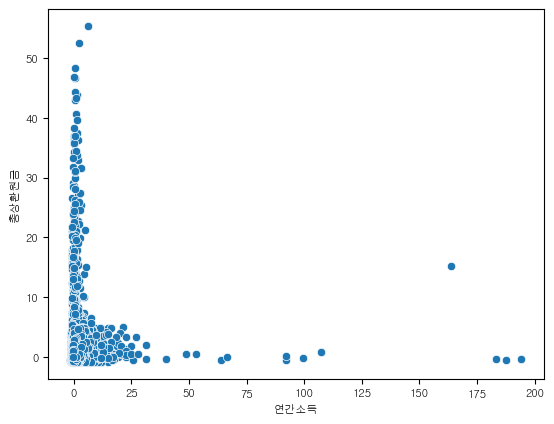

In [20]:
for i in ['대출금액','대출기간','근로기간','연간소득','부채_대비_소득_비율','총계좌수','최근_2년간_연체_횟수','총상환원금','총연체금액','연체계좌수']:
    outliers, length = findOutliers(dataframe,i)
    print(f'해당 칼럼 [{i}] 의 이상치 개수: {length}개')

dataframe[['연간소득','최근_2년간_연체_횟수','총상환원금','연체계좌수']].describe()
plt.figure()
sns.scatterplot(dataframe,x='연간소득',y='총상환원금')
outliers, length = findOutliers(dataframe,'최근_2년간_연체_횟수')
outliers

최근_2년간_연체_횟수 outlier에 1도 포함된 것을 보니 0을 가진 값이 너무 많기에 1도 이상치라고 탐지 한 것 같다.

따라서 최근_2년간_연체_횟수 칼럼은 이상치 변경을 진행하지 않을 것이다.

또한 연간소득과 총상환원금 Scatterplot을 그려보았을 때, 이상치가 크게 튀는 4개의 관측치가 존재했다.

이는 이후 모델 성능에 방해가 될 요소라고 생각되기에 데이터를 삭제를 통해서 특성을 없애기로했다.



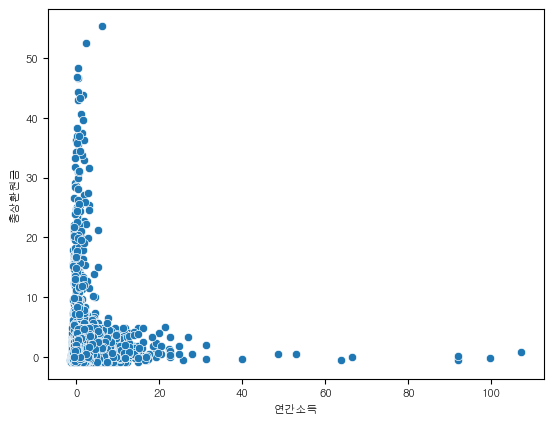

In [21]:
delete_index=dataframe[dataframe['연간소득'] > 150].index

dataframe.drop(index=delete_index,inplace=True)

plt.figure() # 삭제되었는지 확인
sns.scatterplot(dataframe,x='연간소득',y='총상환원금')
plt.show()

# 데이터 분리 및 원핫인코딩

In [22]:
X = dataframe.drop(columns='대출등급')
y = dataframe.pop('대출등급')
oh=OneHotEncoder()
y=oh.fit_transform(y.values.reshape(-1,1)).toarray()
y

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

# 데이터 학습 / 검증 분할 및 학습 및 검증 평가

In [23]:
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.7, test_size=0.3,random_state=42, stratify=y)

X_train

,대출금액,대출기간,근로기간,연간소득,부채_대비_소득_비율,총계좌수,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,...,대출목적_소규모 사업,대출목적_신용 카드,대출목적_의료,대출목적_이사,대출목적_자동차,대출목적_재생 에너지,대출목적_주요 구매,대출목적_주택,대출목적_주택 개선,대출목적_휴가
77141,0.521739,1.0,-0.333333,0.108696,0.453064,1.000000,1.0,0.654434,2.064242,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45602,-0.608696,0.0,1.333333,-0.835217,-0.816137,-0.733333,3.0,0.322144,-0.179036,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
87177,0.086957,0.0,-0.333333,-0.217391,0.194725,-0.400000,2.0,0.919171,0.386529,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32523,0.034783,0.0,-0.333333,-0.630435,1.023274,0.266667,5.0,0.287308,0.066584,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18457,1.739130,1.0,0.833333,0.826087,0.077580,0.266667,0.0,0.749358,4.327741,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96090,0.521739,0.0,0.500000,1.304348,-0.054306,-0.666667,0.0,2.449913,0.368898,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41390,-0.173913,1.0,0.666667,-0.282609,1.201707,-0.066667,0.0,-0.046828,0.110193,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32164,-0.782609,0.0,-0.333333,1.239130,-0.524438,0.400000,3.0,-0.200620,-0.409008,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
55292,-0.347826,0.0,1.166667,-0.065217,0.643910,-0.400000,0.0,0.426700,-0.321185,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier

etc=ExtraTreeClassifier(random_state=42)
rfc=RandomForestClassifier(random_state=42)
dtc=DecisionTreeClassifier(random_state=42)

etc.fit(X_train,y_train) # 학습하기
rfc.fit(X_train,y_train)
dtc.fit(X_train,y_train)

print(f'학습 결과: {etc.score(X_train,y_train)*100:.3f} %, 검증 결과: {etc.score(X_test,y_test)*100:.3f} %')
print(f'학습 결과: {rfc.score(X_train,y_train)*100:.3f} %, 검증 결과: {rfc.score(X_test,y_test)*100:.3f} %')
print(f'학습 결과: {dtc.score(X_train,y_train)*100:.3f} %, 검증 결과: {dtc.score(X_test,y_test)*100:.3f} %')

학습 결과: 100.000 %, 검증 결과: 41.652 %
학습 결과: 99.999 %, 검증 결과: 53.121 %
학습 결과: 100.000 %, 검증 결과: 82.702 %


In [25]:
low_importances_column = []
for i, importances in enumerate(dtc.feature_importances_):
    print(f'칼럼마다 중요도 {dtc.feature_names_in_[i]} : {importances:.4f}')
    if importances < 0.02:
        low_importances_column.append(dtc.feature_names_in_[i])
print(f'중요도 0.02보다 작은 칼럼들: {low_importances_column}')

칼럼마다 중요도 대출금액 : 0.0577
칼럼마다 중요도 대출기간 : 0.0339
칼럼마다 중요도 근로기간 : 0.0161
칼럼마다 중요도 연간소득 : 0.0359
칼럼마다 중요도 부채_대비_소득_비율 : 0.0302
칼럼마다 중요도 총계좌수 : 0.0245
칼럼마다 중요도 최근_2년간_연체_횟수 : 0.0057
칼럼마다 중요도 총상환원금 : 0.4156
칼럼마다 중요도 총상환이자 : 0.3579
칼럼마다 중요도 총연체금액 : 0.0003
칼럼마다 중요도 연체계좌수 : 0.0002
칼럼마다 중요도 주택소유상태_ANY : 0.0000
칼럼마다 중요도 주택소유상태_MORTGAGE : 0.0030
칼럼마다 중요도 주택소유상태_OWN : 0.0025
칼럼마다 중요도 주택소유상태_RENT : 0.0041
칼럼마다 중요도 대출목적_기타 : 0.0015
칼럼마다 중요도 대출목적_부채 통합 : 0.0030
칼럼마다 중요도 대출목적_소규모 사업 : 0.0004
칼럼마다 중요도 대출목적_신용 카드 : 0.0031
칼럼마다 중요도 대출목적_의료 : 0.0006
칼럼마다 중요도 대출목적_이사 : 0.0004
칼럼마다 중요도 대출목적_자동차 : 0.0003
칼럼마다 중요도 대출목적_재생 에너지 : 0.0002
칼럼마다 중요도 대출목적_주요 구매 : 0.0009
칼럼마다 중요도 대출목적_주택 : 0.0003
칼럼마다 중요도 대출목적_주택 개선 : 0.0013
칼럼마다 중요도 대출목적_휴가 : 0.0003
중요도 0.02보다 작은 칼럼들: ['근로기간', '최근_2년간_연체_횟수', '총연체금액', '연체계좌수', '주택소유상태_ANY', '주택소유상태_MORTGAGE', '주택소유상태_OWN', '주택소유상태_RENT', '대출목적_기타', '대출목적_부채 통합', '대출목적_소규모 사업', '대출목적_신용 카드', '대출목적_의료', '대출목적_이사', '대출목적_자동차', '대출목적_재생 에너지', '대출목적_주요 구매', '대출목적_주택', '대출목적_주택 개선', '대출목적_휴

In [26]:
X_train.drop(columns=low_importances_column,inplace=True)
X_test.drop(columns=low_importances_column,inplace=True)
X_train

,대출금액,대출기간,연간소득,부채_대비_소득_비율,총계좌수,총상환원금,총상환이자
77141,0.521739,1.0,0.108696,0.453064,1.000000,0.654434,2.064242
45602,-0.608696,0.0,-0.835217,-0.816137,-0.733333,0.322144,-0.179036
87177,0.086957,0.0,-0.217391,0.194725,-0.400000,0.919171,0.386529
32523,0.034783,0.0,-0.630435,1.023274,0.266667,0.287308,0.066584
18457,1.739130,1.0,0.826087,0.077580,0.266667,0.749358,4.327741
...,...,...,...,...,...,...,...
96090,0.521739,0.0,1.304348,-0.054306,-0.666667,2.449913,0.368898
41390,-0.173913,1.0,-0.282609,1.201707,-0.066667,-0.046828,0.110193
32164,-0.782609,0.0,1.239130,-0.524438,0.400000,-0.200620,-0.409008
55292,-0.347826,0.0,-0.065217,0.643910,-0.400000,0.426700,-0.321185


In [27]:
X_test,y_test

(           대출금액  대출기간      연간소득  부채_대비_소득_비율      총계좌수     총상환원금     총상환이자
 89442  0.382609   0.0 -0.543478     1.206362  0.400000  2.635106  1.951901
 9470   0.000000   0.0  0.326087    -1.186191 -0.066667 -0.799589 -0.658871
 44377 -0.347826   1.0 -0.065217    -0.290147 -0.600000  0.057760  0.152397
 52546  0.521739   1.0  0.152174     0.167572 -0.466667 -0.461857  0.040275
 49634  0.106522   1.0 -0.565217     1.097750 -0.533333 -0.424693  1.292397
 ...         ...   ...       ...          ...       ...       ...       ...
 55543 -0.800000   0.0 -0.543478    -0.674166 -0.933333 -0.620834 -0.534931
 72273 -0.347826   0.0 -0.217391    -0.055857 -0.600000 -0.006967 -0.312948
 88789  1.391304   1.0  1.413043     0.301009  2.133333 -0.293007  0.389835
 95847 -0.591304   0.0  0.108696     0.150504 -0.333333 -0.226466 -0.379532
 96282  0.869565   1.0  0.869565    -0.053530  1.133333 -0.387754  0.214821
 
 [28887 rows x 7 columns],
 array([[0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 1.,

# 중요도 낮은 칼럼들을 제거한 뒤, 다시 Feature 학습 진행

In [28]:
dtc.fit(X_train,y_train)
print(f'학습 결과: {(dtc.score(X_train,y_train)*100):.3f} % | 검증 결과: {(dtc.score(X_test,y_test)*100):.3f} %')
print(f'dtc 모델의 예측 결과: \n {dtc.predict(X_test)}\n정답값:\n {y_test}')

학습 결과: 100.000 % | 검증 결과: 83.435 %
dtc 모델의 예측 결과: 
 [[0. 0. 1. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
정답값:
 [[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [29]:
from sklearn.metrics import f1_score
macro_prediction = f1_score(y_test,dtc.predict(X_test), average='macro')
print(f'macro_f1_score 점수: {macro_prediction*100:.3f}%')

macro_f1_score 점수: 76.019%


# KFold 교차 검증 실행

In [30]:
from sklearn.model_selection import KFold
kf=KFold(n_splits=5,random_state=12,shuffle=True)
X_copy=X.drop(columns=low_importances_column)
y_copy = y
for train_indices,test_indices in kf.split(X_copy): # kf.split(X) : split함수 parameter X에 Features(데이터셋 칼럼)를 대입  
    print(f'학습 인덱스: {train_indices} \n테스트 인덱스: {test_indices}')
    print(f'학습 인덱스의 길이: {len(train_indices)} \n테스트 인덱스의 길이: {len(test_indices)}')
    X_train,X_test = X_copy.iloc[train_indices],X_copy.iloc[test_indices] # iloc 함수로 학습 데이터, 검증 데이터 분할
    y_train,y_test = y[train_indices], y[test_indices]
    print(f'X_train 길이 : {len(X_train)} | y_train 길이 : {len(y_train)}')
    print(f'X_test의 길이 : {len(X_test)} | y_test 길이 : {len(y_test)}')

    model = DecisionTreeClassifier(random_state=42)
    model.fit(X_train,y_train)
    print(f'학습 성능 : {model.score(X_train,y_train)*100:.2f}% | 검증 성능 : {model.score(X_test,y_test)*100:.2f}%')
    macro_prediction = f1_score(y_test,dtc.predict(X_test), average='macro')
    print(f'Macro F1 Score : {macro_prediction:.3f}\n')

학습 인덱스: [    1     4     5 ... 96287 96288 96289] 
테스트 인덱스: [    0     2     3 ... 96258 96270 96278]
학습 인덱스의 길이: 77032 
테스트 인덱스의 길이: 19258
X_train 길이 : 77032 | y_train 길이 : 77032
X_test의 길이 : 19258 | y_test 길이 : 19258
학습 성능 : 100.00% | 검증 성능 : 83.84%
Macro F1 Score : 0.917

학습 인덱스: [    0     1     2 ... 96286 96287 96288] 
테스트 인덱스: [    6    12    14 ... 96268 96282 96289]
학습 인덱스의 길이: 77032 
테스트 인덱스의 길이: 19258
X_train 길이 : 77032 | y_train 길이 : 77032
X_test의 길이 : 19258 | y_test 길이 : 19258
학습 성능 : 100.00% | 검증 성능 : 83.34%
Macro F1 Score : 0.932

학습 인덱스: [    0     1     2 ... 96286 96288 96289] 
테스트 인덱스: [    5     7     8 ... 96284 96285 96287]
학습 인덱스의 길이: 77032 
테스트 인덱스의 길이: 19258
X_train 길이 : 77032 | y_train 길이 : 77032
X_test의 길이 : 19258 | y_test 길이 : 19258
학습 성능 : 100.00% | 검증 성능 : 83.68%
Macro F1 Score : 0.923

학습 인덱스: [    0     1     2 ... 96287 96288 96289] 
테스트 인덱스: [    9    11    24 ... 96273 96276 96277]
학습 인덱스의 길이: 77032 
테스트 인덱스의 길이: 19258
X_train 길이 : 77032 | y_train 길이 

## KFold 학습 검증 결과는 83.84 %가 최고 성능

# Deep_Learning 딥러닝 모델

In [31]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape
y_train,y_test
y_test

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [32]:
model = tf.keras.Sequential([
    Dense(128,activation='relu'),
    Dense(7,activation='softmax')
])
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

es = EarlyStopping('val_accuracy',patience=4)
mc = ModelCheckpoint('best_model.h5',monitor='val_accuracy',save_best_only=True)
history=model.fit(X_train,y_train, epochs= 30,validation_data=(X_test,y_test),callbacks=[es,mc])


Epoch 1/30
2408/2408 [==============================] - 3s 1ms/step - loss: 1.1036 - accuracy: 0.5622 - val_loss: 0.8804 - val_accuracy: 0.6660
Epoch 2/30
2408/2408 [==============================] - 2s 858us/step - loss: 0.7925 - accuracy: 0.7020 - val_loss: 0.7295 - val_accuracy: 0.7353
Epoch 3/30
2408/2408 [==============================] - 2s 815us/step - loss: 0.6974 - accuracy: 0.7457 - val_loss: 0.6716 - val_accuracy: 0.7677
Epoch 4/30
2408/2408 [==============================] - 2s 880us/step - loss: 0.6517 - accuracy: 0.7662 - val_loss: 0.6446 - val_accuracy: 0.7707
Epoch 5/30
2408/2408 [==============================] - 2s 882us/step - loss: 0.6268 - accuracy: 0.7773 - val_loss: 0.6218 - val_accuracy: 0.7805
Epoch 6/30
2408/2408 [==============================] - 2s 863us/step - loss: 0.6091 - accuracy: 0.7864 - val_loss: 0.6116 - val_accuracy: 0.7870
Epoch 7/30
2408/2408 [==============================] - 2s 857us/step - loss: 0.5973 - accuracy: 0.7915 - val_loss: 0.5960 - v

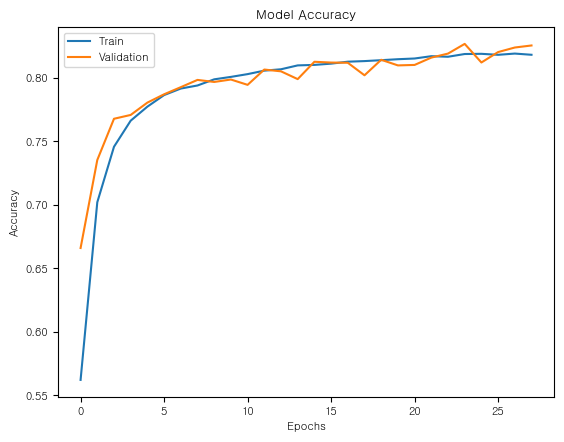

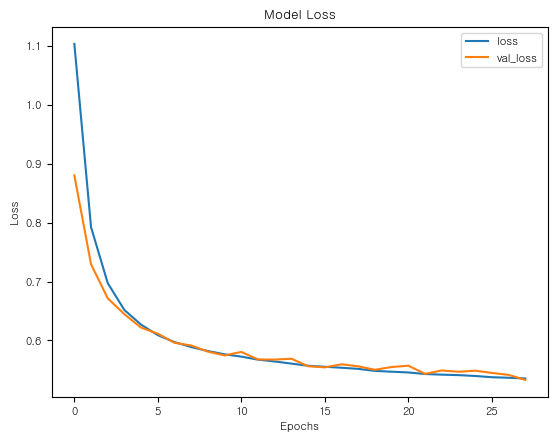

In [33]:
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train','Validation'])
plt.show()

plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [34]:
X_train

,대출금액,대출기간,연간소득,부채_대비_소득_비율,총계좌수,총상환원금,총상환이자
0,-0.313043,0.0,-0.108696,0.012413,-0.600000,-0.799589,-0.658871
2,-0.347826,0.0,0.326087,-0.786656,-0.666667,0.442737,-0.310055
3,-0.173913,0.0,0.978261,-0.283165,-0.600000,-0.363706,-0.307383
5,-0.869565,0.0,0.108696,-0.384794,0.400000,-0.478232,-0.531625
6,-0.956522,0.0,-0.413043,-0.203258,-0.133333,-0.695386,-0.552479
...,...,...,...,...,...,...,...
96286,1.826087,1.0,3.021739,0.004655,1.800000,1.744927,4.106584
96288,0.315217,0.0,-0.500000,1.252909,0.333333,1.182335,0.765207
96289,-0.173913,0.0,2.391304,-0.730023,0.600000,0.504190,0.470992
96291,-0.173913,0.0,0.108696,-0.581846,-0.133333,1.192545,-0.105069


In [35]:
test = pd.read_csv(r'C:\Users\hyssk\AICE_\open\test.csv')
test=test.drop('ID',axis=1)
test=test[['대출금액','대출기간', '연간소득', '부채_대비_소득_비율', '총계좌수', '총상환원금', '총상환이자']]
rs=RobustScaler()
for col in ['대출금액', '연간소득', '부채_대비_소득_비율', '총계좌수', '총상환원금', '총상환이자']:
    test[col] = rs.fit_transform(test[[col]])

le= LabelEncoder()
test['대출기간']=le.fit_transform(test['대출기간']).reshape(-1,1)
test

,대출금액,대출기간,연간소득,부채_대비_소득_비율,총계좌수,총상환원금,총상환이자
0,0.000000,0,0.978240,0.067285,-0.800000,-0.270784,-0.318157
1,-0.603448,0,0.216865,-0.226605,0.066667,-0.794718,-0.649044
2,0.034483,0,1.304319,-0.801237,-0.266667,1.577409,-0.012973
3,-0.172414,0,-0.217387,-0.390565,0.400000,0.093378,-0.013190
4,0.775862,0,-0.413034,0.907193,-0.800000,0.864664,0.738665
...,...,...,...,...,...,...,...
64192,0.948276,0,0.000000,0.255994,0.200000,0.940966,1.073913
64193,0.948276,1,0.565205,-0.518948,0.133333,0.480447,2.161503
64194,-0.767241,0,-0.695637,0.775715,0.600000,-0.620132,-0.466497
64195,-0.379310,0,-0.217387,0.515855,1.133333,0.983449,0.709387


In [36]:
answersheet = []
for i in dtc.predict(test):
    answersheet.append([list(i).index(1)])
answersheet=pd.DataFrame(answersheet)
answersheet=answersheet[0].map({0:'A',1:'B',2:'C',3:'D',4:'E',5:'F',6:'G'})
answersheet

0        B
1        B
2        A
3        C
4        C
        ..
64192    D
64193    D
64194    B
64195    C
64196    A
Name: 0, Length: 64197, dtype: object

In [46]:
sub = pd.read_csv(r'C:\Users\hyssk\AICE_\open\sample_submission.csv',encoding='UTF-8')
sub['대출등급'] = answersheet
sub

,Unnamed: 0,ID,대출등급
0,0,TEST_00000,B
1,1,TEST_00001,B
2,2,TEST_00002,A
3,3,TEST_00003,C
4,4,TEST_00004,C
...,...,...,...
64192,64192,TEST_64192,D
64193,64193,TEST_64193,D
64194,64194,TEST_64194,B
64195,64195,TEST_64195,C


In [47]:
sub.drop(columns=['Unnamed: 0'],inplace=True)

In [52]:
sub.to_csv('sample_submission.csv',encoding='UTF-8')
sub

,ID,대출등급
0,TEST_00000,B
1,TEST_00001,B
2,TEST_00002,A
3,TEST_00003,C
4,TEST_00004,C
...,...,...
64192,TEST_64192,D
64193,TEST_64193,D
64194,TEST_64194,B
64195,TEST_64195,C
